# Training and explaining AI model on Kickstarter dataset

### Filename = Single CSV file obtained after running prepare_dataset.py

In [1]:
FILENAME = "full_dataset.csv"

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import lime
import lime.lime_tabular
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lime
import lime.lime_text

## Data Exploration

In [3]:
df = pd.read_csv(FILENAME, low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1788003 entries, 0 to 1788002
Data columns (total 27 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Unnamed: 0                int64  
 1   backers_count             int64  
 2   blurb                     object 
 3   category                  object 
 4   converted_pledged_amount  float64
 5   country                   object 
 6   goal                      float64
 7   id                        int64  
 8   location                  object 
 9   name                      object 
 10  photo                     int64  
 11  pledged                   float64
 12  spotlight                 int64  
 13  staff_pick                int64  
 14  state                     int64  
 15  usd_pledged               float64
 16  video                     int64  
 17  prelaunch_activated       int64  
 18  is_liked                  int64  
 19  is_disliked               int64  
 20  is_starrable            

In [5]:
df['state'].value_counts()

state
1    1123662
0     664341
Name: count, dtype: int64

In [6]:
df['video'].value_counts()

video
1    1243983
0     544020
Name: count, dtype: int64

In [7]:
df['photo'].value_counts()

photo
1    1787768
0        235
Name: count, dtype: int64

In [8]:
df["blurb"] = df["blurb"].astype(str)

In [9]:
df_spot = df[df["spotlight"]==1]
print(df_spot["state"].value_counts())

state
1    1123662
Name: count, dtype: int64


#### Some columns can be dropped as they are not relevant/similar to others 

In [10]:
df = df.drop(columns=['Unnamed: 0','id','name','location','converted_pledged_amount','usd_pledged'])

#### Full dataset is too big to process locally. We will randomly sample 10,000 records

In [11]:
df_sampled = df.sample(n=10000, random_state=42).reset_index(drop=True)

In [12]:
df.columns

Index(['backers_count', 'blurb', 'category', 'country', 'goal', 'photo',
       'pledged', 'spotlight', 'staff_pick', 'state', 'video',
       'prelaunch_activated', 'is_liked', 'is_disliked', 'is_starrable',
       'blurb_wc', 'dale_chall', 'flesch_kincaid', 'smog', 'gun_fog',
       'camp_len'],
      dtype='object')

#### Target class = state 
(1 - successful, 0 - failed) 

In [13]:
df_sampled["state"].value_counts()

state
1    6261
0    3739
Name: count, dtype: int64

In [14]:
X_blurb = df_sampled["blurb"]
y = df_sampled["state"]
X_other = df_sampled.drop(columns=["blurb", "state"])

In [15]:
X_other

backers_count          category country     goal  photo   pledged  \
0                30           Jewelry      CA   2200.0      1   3390.00   
1               109       Anthologies      US   2156.0      1   2237.00   
2                 0         Wearables      US  10000.0      1      0.00   
3                 1            Comedy      NZ   7000.0      1      5.00   
4                22      Illustration      US    500.0      1   1674.00   
...             ...               ...     ...      ...    ...       ...   
9995             26  Children's Books      US    880.0      1   1297.00   
9996             26           Fiction      AU    786.0      1    996.32   
9997            116           Gadgets      US  12500.0      1  14450.00   
9998              0         Sculpture      FR  10000.0      1      0.00   
9999              0             Blues      AU   7500.0      1      0.00   

      spotlight  staff_pick  video  prelaunch_activated  is_liked  \
0             1           0      1                    0         0   
1             1           0      1                    0         0   
2             0           0      1                    0         0   
3             0           0      0                    0         0   
4             1           0      0                    1         0   
...         ...         ...    ...                  ...       ...   
9995          1           0      0                    1         0   
9996          1           0      1                    1         0   
9997          1           0      1                    0         0   
9998          0           0      0                    0         0   
9999          0           0      1                    0         0   

      is_disliked  is_starrable  blurb_wc  dale_chall  flesch_kincaid  smog  \
0               0             0        20       12.52           42.72   0.0   
1               0             0        20       12.82           44.41   0.0   
2               0             0        15       14.91           30.87   0.0   
3               0             0        18       10.67           44.75   0.0   
4               0             0        18       11.55           44.75   0.0   
...           ...           ...       ...         ...             ...   ...   
9995            0             0        20        8.58           25.80   0.0   
9996            0             0        20       11.07           47.75  10.5   
9997            0             0        21        7.16           69.28   0.0   
9998            0             0        16       18.25           63.70   0.0   
9999            0             0        23       10.27           48.13   0.0   

      gun_fog  camp_len  
0       14.00         1  
1       10.00         1  
2       14.00         1  
3       13.87         1  
4       13.87         0  
...       ...       ...  
9995    14.00         2  
9996    12.68         1  
9997     8.01         1  
9998    11.40         1  
9999    14.42         1  

[10000 rows x 19 columns]

## Feature engineering

#### Create TF IDF Vectors

In [16]:
tf_vector = TfidfVectorizer(ngram_range=(2, 2), \
                    stop_words='english', \
                    max_features=1000)  # remove stopwords and choose top 1000 features
tf_idf = tf_vector.fit_transform(X_blurb)

#### Choose best k vectors based on chi^2 metric

In [17]:
scores = []
for k in range(100, 1001, 100):
    sel = SelectKBest(score_func=chi2, k=k).fit(tf_idf, y)
    X_k = sel.transform(tf_idf)
    acc = cross_val_score(MultinomialNB(), X_k, y, cv=5).mean()
    scores.append((k, acc))

best_k, best_acc = max(scores, key=lambda x: x[1])
print(f"Best k: {best_k}, Accuracy: {best_acc:.3f}")

Best k: 400, Accuracy: 0.668


#### Use only k best features

In [18]:
tf_vector = TfidfVectorizer(ngram_range=(2, 2), \
                    stop_words='english', \
                    max_features=400)  # remove stopwords and choose top 400 features (Best fit)
tf_idf = tf_vector.fit_transform(X_blurb)

In [19]:
# numeric = ["backers_count", "converted_pledged_amount", "goal", "pledged", "blurb_wc", "dale_chall", "flesch_kincaid", "smog", "gun_fog", "camp_len"]
categorical = X_other.select_dtypes(include=['object', 'category']).columns.tolist()
numeric = X_other.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()

In [20]:
other_text_cols = ['blurb_wc', 'dale_chall', 'flesch_kincaid', 'smog', 'gun_fog']

#### The categorical features will be one hot encoded, and numeric features will be scaled 

In [21]:
transformer = ColumnTransformer([
        ('cat', OneHotEncoder(sparse_output=False), categorical),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric)
    ])

In [22]:
X_transformed = transformer.fit_transform(X_other)

In [23]:
X_text = hstack([tf_idf, X_other[other_text_cols]])
X_final = hstack([X_transformed, tf_idf])
X_only_campaign_features = X_other.drop(columns=other_text_cols)

In [24]:
print(transformer.transformers_[1][2])

['backers_count', 'goal', 'photo', 'pledged', 'spotlight', 'staff_pick', 'video', 'prelaunch_activated', 'is_liked', 'is_disliked', 'is_starrable', 'blurb_wc', 'dale_chall', 'flesch_kincaid', 'smog', 'gun_fog', 'camp_len']


In [25]:
onehot_feature_names = transformer.named_transformers_['cat'].get_feature_names_out()
numeric_features = transformer.transformers_[1][2]
tfidf_feature_names = tf_vector.get_feature_names_out()
all_feature_names = np.concatenate([onehot_feature_names, numeric_features, tfidf_feature_names])
X_dense = X_final.toarray()

# Final df
X_df = pd.DataFrame(X_dense, columns=all_feature_names)
X_tfidf_df = pd.DataFrame(tf_idf.toarray(), columns=tf_vector.get_feature_names_out())
X_text_df = pd.concat([X_tfidf_df, X_other[other_text_cols]], axis=1)
X_only_campaign_features = X_df.drop(columns=other_text_cols)

In [26]:
X_df.head()

category_3D Printing  category_Academic  category_Accessories  \
0                   0.0                0.0                   0.0   
1                   0.0                0.0                   0.0   
2                   0.0                0.0                   0.0   
3                   0.0                0.0                   0.0   
4                   0.0                0.0                   0.0   

   category_Action  category_Animals  category_Animation  \
0              0.0               0.0                 0.0   
1              0.0               0.0                 0.0   
2              0.0               0.0                 0.0   
3              0.0               0.0                 0.0   
4              0.0               0.0                 0.0   

   category_Anthologies  category_Apparel  category_Apps  \
0                   0.0               0.0            0.0   
1                   1.0               0.0            0.0   
2                   0.0               0.0            0.0   
3                   0.0               0.0            0.0   
4                   0.0               0.0            0.0   

   category_Architecture  ...  year round  years ago  years making  years old  \
0                    0.0  ...         0.0        0.0           0.0        0.0   
1                    0.0  ...         0.0        0.0           0.0        0.0   
2                    0.0  ...         0.0        0.0           0.0        0.0   
3                    0.0  ...         0.0        0.0           0.0        0.0   
4                    0.0  ...         0.0        0.0           0.0        0.0   

   york city  young adult  young girl  young man  young people  young woman  
0        0.0          0.0         0.0        0.0           0.0          0.0  
1        0.0          0.0         0.0        0.0           0.0          0.0  
2        0.0          0.0         0.0        0.0           0.0          0.0  
3        0.0          0.0         0.0        0.0           0.0          0.0  
4        0.0          0.0         0.0        0.0           0.0          0.0  

[5 rows x 598 columns]

## Model training

In [27]:
def random_forest(X, y, X_test, y_test):
    rf = RandomForestClassifier()
    rf.fit(X, y)
    rf_pred = rf.predict(X_test)
    rf_proba = rf.predict_proba(X_test)[:, 1]
    print("RF AUC:", roc_auc_score(y_test, rf_proba))
    print("RF F1:", f1_score(y_test, rf_pred))

def logistic_regression(X, y, X_test, y_test):
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X, y)
    lr_pred = lr.predict(X_test)
    lr_proba = lr.predict_proba(X_test)[:, 1]
    print("LR AUC:", roc_auc_score(y_test, lr_proba))
    print("LR F1:", f1_score(y_test, lr_pred))

In [28]:
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text_df, y, test_size=0.2, stratify=y, random_state=42)

### MODEL 1 -Text only Model

In [29]:
model_text = XGBClassifier(eval_metric='logloss', 
                           scale_pos_weight=3,
                           max_depth=16, 
                           learning_rate=0.1, 
                           reg_alpha=0.1, 
                           reg_lambda=0.25)

# Based on Grid Search (below)
# {'learning_rate': 0.1, 'max_depth': 16, 'reg_alpha': 0.1, 'reg_lambda': 0.25, 'scale_pos_weight': 3}

In [30]:
# Random Forest text only
random_forest(X_train_text, y_train, X_test_text, y_test)

# Logistic Regression text only
logistic_regression(X_train_text, y_train, X_test_text, y_test)

RF AUC: 0.5891157036442227
RF F1: 0.6887519260400616
LR AUC: 0.6258702653294835
LR F1: 0.7696774193548387


In [31]:
model_text.fit(X_train_text, y_train)

# Evaluate
y_pred_text = model_text.predict(X_test_text)
y_proba_text = model_text.predict_proba(X_test_text)[:, 1]

print("Text-only AUC:", roc_auc_score(y_test, y_proba_text))
print("Text-only F1:", f1_score(y_test, y_pred_text))

Text-only AUC: 0.6099454776101554
Text-only F1: 0.7670116023831922


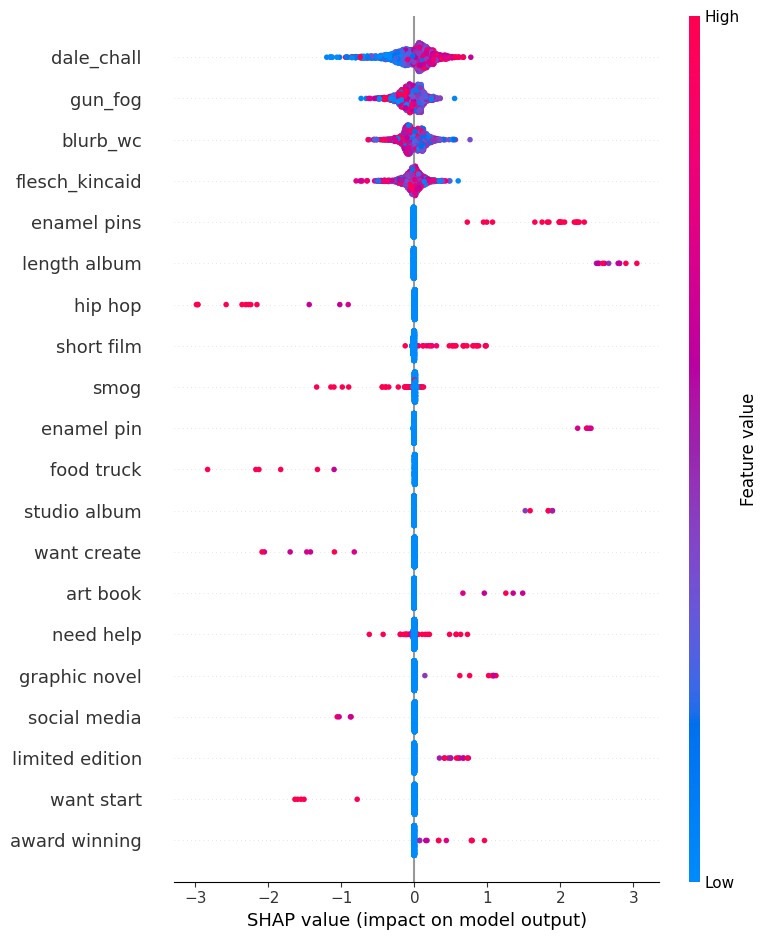

In [32]:
# Explain model 1 (text-only)
explainer_text = shap.TreeExplainer(model_text)
shap_values_text = explainer_text.shap_values(X_test_text)

shap.summary_plot(shap_values_text, X_test_text)


# 

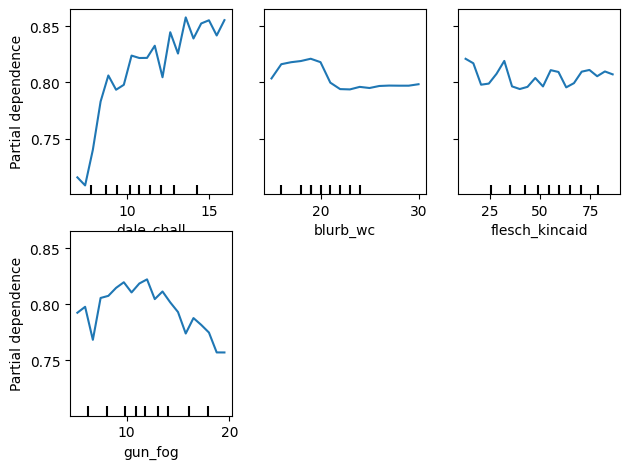

In [33]:
features=['dale_chall', 'blurb_wc', 'flesch_kincaid', 'gun_fog']  

PartialDependenceDisplay.from_estimator(
    model_text,
    X_test_text,
    features,
    kind="average", 
    subsample=50,  
    grid_resolution=20,
    random_state=42
)

plt.tight_layout()
plt.show()

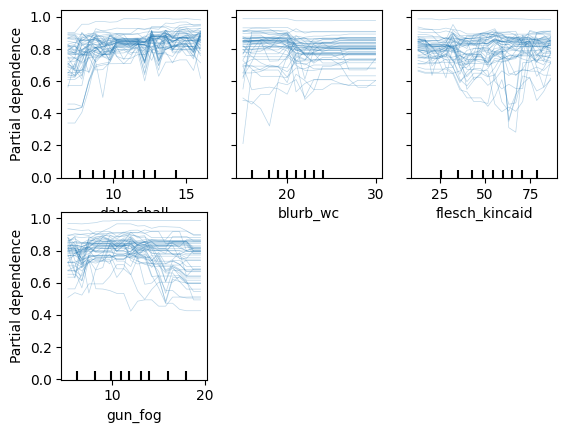

In [34]:
PartialDependenceDisplay.from_estimator(
    model_text,
    X_test_text,
    features,
    kind="individual", 
    subsample=50,  
    grid_resolution=20,
    random_state=42
)

***

# 

### MODEL 2 - Text + Features Model

In [35]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_df, y, test_size=0.2, stratify=y, random_state=42)

In [36]:
# Random Forest text + other features
random_forest(X_train_all, y_train_all, X_test_all, y_test_all)

# Logistic Regression text + other features
logistic_regression(X_train_all, y_train_all, X_test_all, y_test_all)

RF AUC: 1.0
RF F1: 1.0
LR AUC: 1.0
LR F1: 1.0


100% accuracy is suspicious, let us look for an explanation

In [37]:
model_all = XGBClassifier(eval_metric='logloss', 
                          scale_pos_weight=1,
                          max_depth=8, 
                          learning_rate=0.1, 
                          reg_alpha=0.1, 
                          reg_lambda=0.1)

# Based on Grid Search (below)
# Best Params: {'learning_rate': 0.1, 'max_depth': 8, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'scale_pos_weight': 1}

model_all.fit(X_train_all, y_train_all)

# Evaluate
y_pred_all = model_all.predict(X_test_all)
y_proba_all = model_all.predict_proba(X_test_all)[:, 1]

print("All features AUC:", roc_auc_score(y_test_all, y_proba_all))
print("All features F1:", f1_score(y_test_all, y_pred_all))

All features AUC: 1.0
All features F1: 1.0


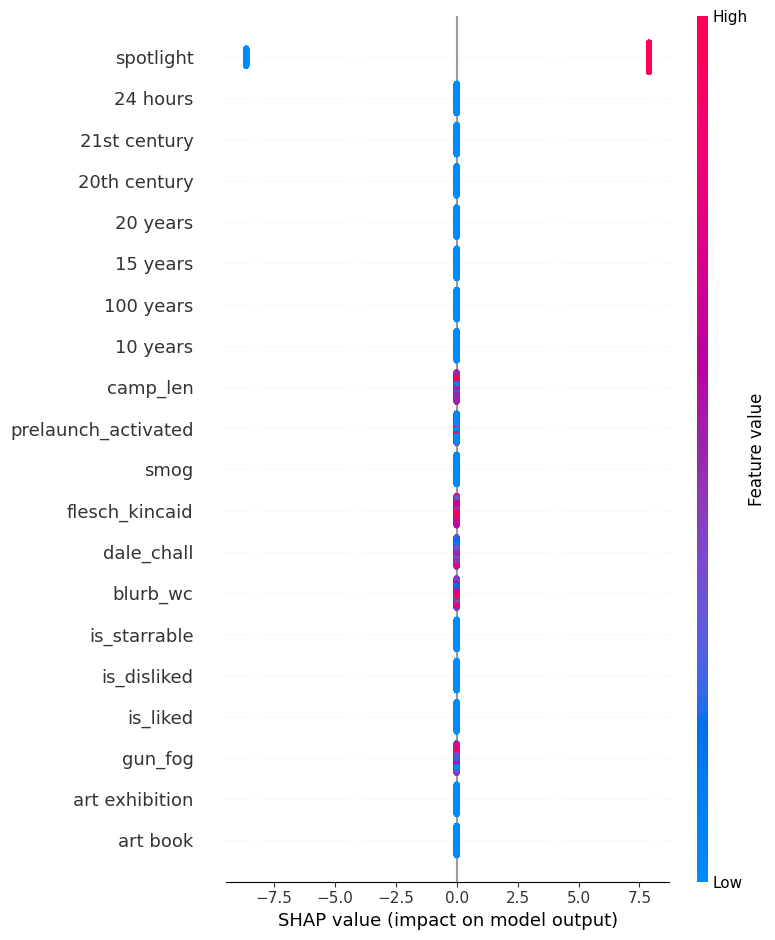

In [38]:
# Explain model 2 (all features)
explainer_all = shap.TreeExplainer(model_all)
shap_values_all = explainer_all.shap_values(X_test_all)

shap.summary_plot(shap_values_all, X_test_all)

# 

In [39]:
df_sampled_spot = df_sampled[df_sampled["spotlight"]==1]
print(df_sampled_spot["state"].value_counts())

state
1    6261
Name: count, dtype: int64


#### Spotlight is only present on successful projects, it can be droppped as a feature

In [40]:
X_df = X_df.drop(columns='spotlight')

In [41]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_df, y, test_size=0.2, stratify=y, random_state=42)

In [42]:
# Random Forest text + other features
random_forest(X_train_all, y_train_all, X_test_all, y_test_all)

# Logistic Regression text + other features
logistic_regression(X_train_all, y_train_all, X_test_all, y_test_all)

RF AUC: 0.9942258162341323
RF F1: 0.9683470105509965
LR AUC: 0.9441887632194905
LR F1: 0.8992310805341966


In [43]:
model_all = XGBClassifier(eval_metric='logloss', 
                          scale_pos_weight=1,
                          max_depth=8, 
                          learning_rate=0.1, 
                          reg_alpha=0.1, 
                          reg_lambda=0.1)
# Based on Grid Search (below)
# Best Params: {'learning_rate': 0.1, 'max_depth': 8, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'scale_pos_weight': 1}

model_all.fit(X_train_all, y_train_all)

# Evaluate
y_pred_all = model_all.predict(X_test_all)
y_proba_all = model_all.predict_proba(X_test_all)[:, 1]

print("All features AUC:", roc_auc_score(y_test_all, y_proba_all))
print("All features F1:", f1_score(y_test_all, y_pred_all))

All features AUC: 0.9998590490509301
All features F1: 0.994435612082671


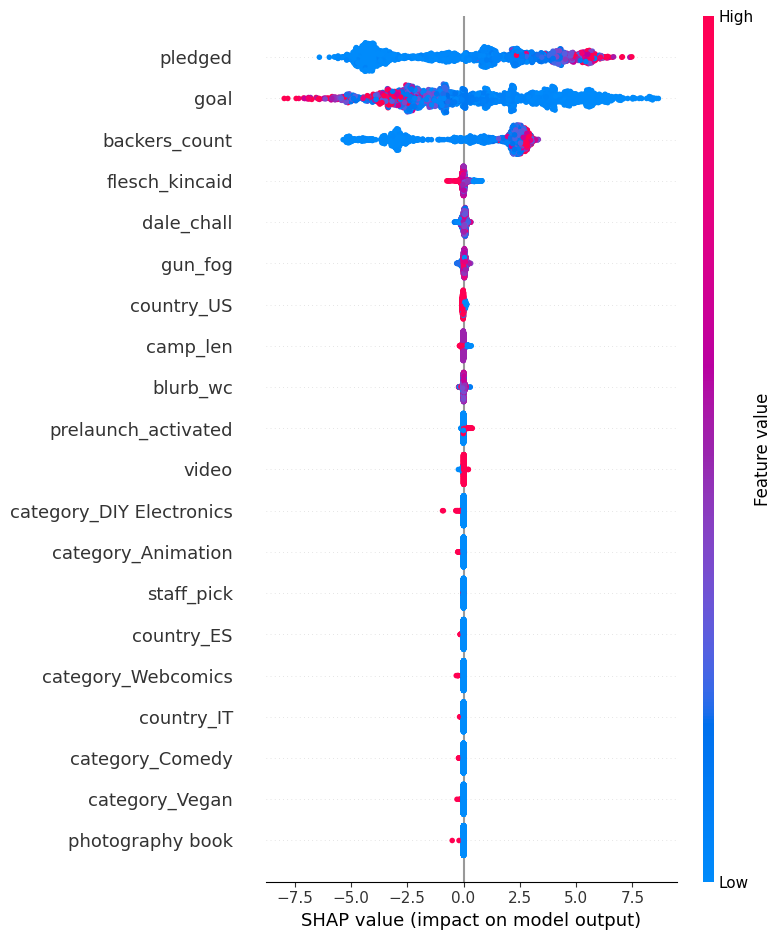

In [44]:
# Explain model 2 (all features)
explainer_all = shap.TreeExplainer(model_all)
shap_values_all = explainer_all.shap_values(X_test_all)

shap.summary_plot(shap_values_all, X_test_all)

#

#### "Pledged" and "Backers count" are very strong social proof indicators of how successful a project is. However, this cannot be controlled by the campaign organisers beforehand. We want to study effects of features that can be controlled by the campaign organiser, thus we remove these features as well.

In [45]:
X_df = X_df.drop(columns=['pledged','backers_count'])

In [46]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_df, y, test_size=0.2, stratify=y, random_state=42)

In [47]:
model_all = XGBClassifier(eval_metric='logloss', 
                          scale_pos_weight=1,
                          max_depth=8, 
                          learning_rate=0.1, 
                          reg_alpha=0.1, 
                          reg_lambda=0.1)
# Based on Grid Search (below)
# Best Params: {'learning_rate': 0.1, 'max_depth': 8, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'scale_pos_weight': 1}

model_all.fit(X_train_all, y_train_all)

# Evaluate
y_pred_all = model_all.predict(X_test_all)
y_proba_all = model_all.predict_proba(X_test_all)[:, 1]

print("All features AUC:", roc_auc_score(y_test_all, y_proba_all))
print("All features F1:", f1_score(y_test_all, y_pred_all))

All features AUC: 0.8897800951632469
All features F1: 0.8546221710778673


In [48]:
# Random Forest text + other features
random_forest(X_train_all, y_train_all, X_test_all, y_test_all)

# Logistic Regression text + other features
logistic_regression(X_train_all, y_train_all, X_test_all, y_test_all)

RF AUC: 0.8888916770600195
RF F1: 0.8535080956052429
LR AUC: 0.8781756675949497
LR F1: 0.8402695204122077


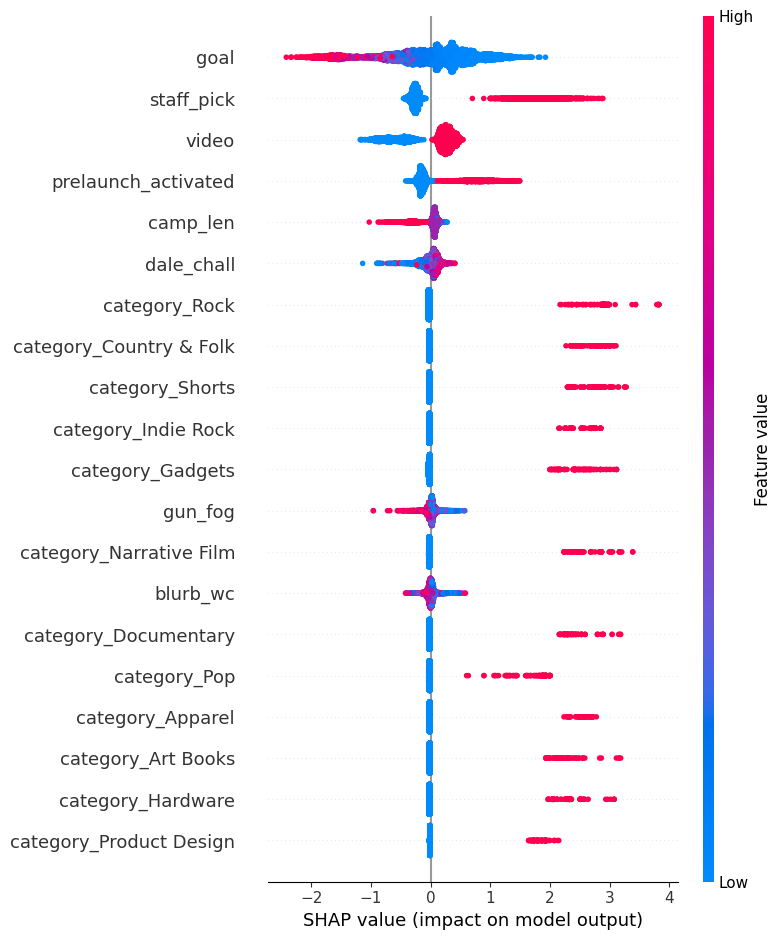

In [65]:
# Explain model 2 (all features)
explainer_all = shap.TreeExplainer(model_all)
shap_values_all = explainer_all.shap_values(X_train_all)

shap.summary_plot(shap_values_all, X_test_all)

# 

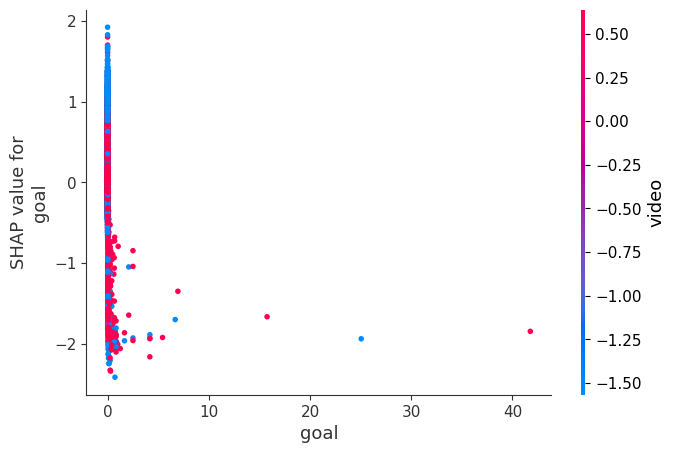

In [69]:
shap.dependence_plot('goal',                 
                shap_values_all,     
                X_test_all,            
                # interaction_index=None  
)

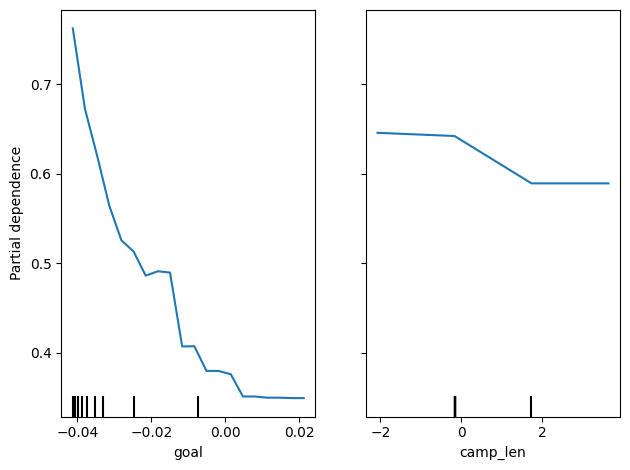

In [51]:
features=['goal', 'camp_len']  

PartialDependenceDisplay.from_estimator(
    model_all,
    X_test_all,
    features,
    kind="average", 
    subsample=50,  
    grid_resolution=20,
    random_state=42
)

plt.tight_layout()
plt.show()

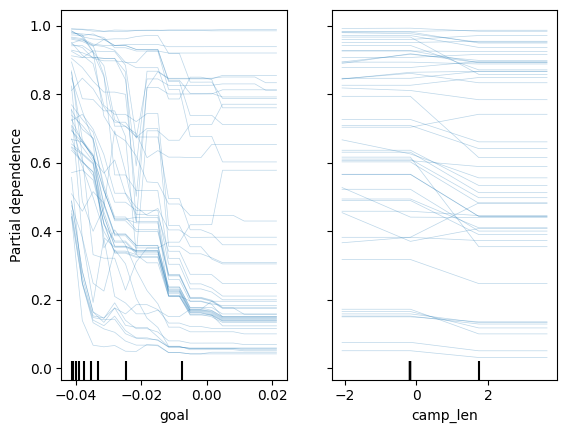

In [52]:
PartialDependenceDisplay.from_estimator(
    model_all,
    X_test_all,
    features,
    kind="individual", 
    subsample=50,  
    grid_resolution=20,
    random_state=42
)

# 

## Local Explanations using LIME

#### We find the projects that were close to reaching their goal in order to generate explanations for them (80% funded)

In [53]:
to_explain = X_test_all.copy()
to_explain["state"] = y_test_all
to_explain["goal"] = df_sampled.loc[X_test_all.index, 'goal']
to_explain["pledged"] = df_sampled.loc[X_test_all.index, 'pledged']
to_explain = to_explain[ (to_explain["pledged"] < to_explain["goal"]) & (to_explain["pledged"] >= 0.8*to_explain["goal"]) ]
to_explain = to_explain.drop(columns=['state','pledged'])

In [54]:
to_explain.head()

category_3D Printing  category_Academic  category_Accessories  \
880                    0.0                0.0                   0.0   
6828                   0.0                0.0                   0.0   

      category_Action  category_Animals  category_Animation  \
880               0.0               0.0                 0.0   
6828              0.0               0.0                 0.0   

      category_Anthologies  category_Apparel  category_Apps  \
880                    0.0               0.0            0.0   
6828                   0.0               0.0            0.0   

      category_Architecture  ...  year round  years ago  years making  \
880                     0.0  ...         0.0        0.0           1.0   
6828                    0.0  ...         0.0        0.0           0.0   

      years old  york city  young adult  young girl  young man  young people  \
880         0.0        0.0          0.0         0.0        0.0           0.0   
6828        0.0        0.0          0.0         0.0        0.0           0.0   

      young woman  
880           0.0  
6828          0.0  

[2 rows x 595 columns]

In [55]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_all),
    feature_names=X_train_all.columns.tolist(),
    class_names=['fail', 'success'],
    categorical_features=categorical,
    discretize_continuous=True,
    mode='classification'
)

In [56]:
idx = 0
instance = to_explain.iloc[idx].values

# Explain the prediction
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=model_all.predict_proba
)
exp.show_in_notebook()
exp.save_to_file(f'Lime_{idx}.html')

In [57]:
idx = 1
instance = to_explain.iloc[idx].values

# Explain the prediction
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=model_all.predict_proba
)
exp.show_in_notebook()
exp.save_to_file(f'Lime_{idx}.html')

## Grid search

In [58]:
params = {
    'max_depth': [4, 6, 8, 16],
    'learning_rate': [0.05, 0.1, 0.001],
    'scale_pos_weight': [1, 3, 5],
    'reg_alpha': [0.1, 0.25, 0.5],
    'reg_lambda': [0.1, 0.25, 0.5, 1]
}

In [59]:
grid_text = GridSearchCV(XGBClassifier(eval_metric='logloss'), 
                    param_grid=params, 
                    scoring='roc_auc', 
                    cv=3, 
                    verbose=1)

grid_text.fit(X_train_text, y_train)
print("Best Params {Text}:", grid_text.best_params_)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Params {Text}: {'learning_rate': 0.1, 'max_depth': 16, 'reg_alpha': 0.1, 'reg_lambda': 0.25, 'scale_pos_weight': 3}


In [60]:
grid_all = GridSearchCV(XGBClassifier(eval_metric='logloss'), 
                    param_grid=params, 
                    scoring='roc_auc', 
                    cv=3, 
                    verbose=1)

grid_all.fit(X_train_all, y_train_all)
print("Best Params {All}:", grid_all.best_params_)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Params {All}: {'learning_rate': 0.1, 'max_depth': 8, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'scale_pos_weight': 1}
